### PPO (image obs based CNN network)
To generalize the learning process, we train the agent on **100 diverse scenarios** from the MetaDrive environment. These scenarios are specified using the `num_scenarios=100` setting in the environment configuration, ensuring the agent experiences a wide variety of traffic and road layouts during training. This enhances the robustness and generalization ability of the policy.

We structure the training using:
- `EPISODES_PER_BATCH = 32`: Each epoch collects trajectories from 32 complete episodes.
- `TOTAL_EPOCHS = 100`: We train for 100 epochs, where each epoch involves collecting a new batch of experience and performing PPO updates.
- `PPO_STEPS = 10`: The collected batch is used to update the policy and value networks multiple times (10 steps per epoch), increasing sample efficiency.

The training loop follows the standard PPO structure:
1. Collect trajectories for `EPISODES_PER_BATCH` episodes using the current policy.
2. Compute rewards-to-go and GAE-based advantages.
3. Normalize the advantages for stability.
4. Perform `PPO_STEPS` rounds of policy updates using the clipped surrogate loss.
5. Save model checkpoints and optionally record a video of the agent’s behavior.

For evaluation, we randomly select **5 fixed scenarios** from the test set (using specific `start_seed` values). This allows us to assess the generalization capability of the trained policy under consistent conditions and compare performance across models.

Overall, this training setup balances exploration diversity, computational efficiency, and reproducibility.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio
from torch.distributions import Normal
import matplotlib.pyplot as plt
from metadrive.envs.top_down_env import TopDownMetaDrive

In [ ]:
# Training hyperparameters
SEED = 42
TOTAL_EPOCHS = 100
EPISODES_PER_BATCH = 32
GAMMA = 0.9
GAE_LAMBDA = 0.95
CLIP_EPS = 0.07
PPO_STEPS = 10
BATCH_SIZE = 64
ACTOR_LR = 5e-5
CRITIC_LR = 1e-3
ENTROPY_COEF = 0.01
SAVE_EVERY = 10
RENDER_EVERY = 20
VIDEO_DIR = "ppo_checkpoints/videos"
MODEL_DIR = "ppo_checkpoints/models"

np.random.seed(SEED)
torch.manual_seed(SEED)

# Convert image observations to tensors (B, C, H, W)
def preprocess_obs(obs_list, device):
    return torch.tensor(np.stack(obs_list), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

# Generalized Advantage Estimation (GAE): 
def compute_gae(rewards, values, gamma=GAMMA, lam=GAE_LAMBDA):
    advantages = []
    gae = 0
    values = values + [0.0]
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    returns = [adv + v for adv, v in zip(advantages, values[:-1])]
    return advantages, returns

# Log-Prob Correction after Tanh Squash: 
def squash_log_prob(dist, raw_action, tanh_action):
    log_prob = dist.log_prob(raw_action).sum(dim=-1)
    log_prob -= torch.log(1 - tanh_action.pow(2) + 1e-6).sum(dim=-1)
    return log_prob


In [ ]:
# Record agent’s behavior on current map using the current policy.
# This allows visual inspection of learning progress and qualitative debugging.
@torch.no_grad()
def record_video(actor, env, device, epoch, max_frames=1000):
    os.makedirs(VIDEO_DIR, exist_ok=True)
    frames = []
    obs, _ = env.reset()
    for _ in range(max_frames):
        obs_tensor = preprocess_obs([obs], device)
        mu, std = actor(obs_tensor)
        dist = Normal(mu, std)
        raw_action = dist.mean
        action = torch.tanh(raw_action).squeeze(0).cpu().numpy()
        img = env.render(mode="topdown")
        if img is not None:
            frames.append(img)
        obs, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    path = os.path.join(VIDEO_DIR, f"video_epoch_{epoch}.mp4")
    imageio.mimsave(path, frames, fps=15)
    print(f"[Video] Saved to {path}")
    

In [4]:
# Actor network
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 9 * 9, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, 2)
        self.log_std = nn.Parameter(torch.full((2,), -0.5))

    def forward(self, obs_tensor):
        x = self.conv(obs_tensor)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        mu = self.mu(x)
        std = self.log_std.exp().expand_as(mu)
        return mu, std

# Critic network
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 9 * 9, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x).squeeze(-1)

In [ ]:
def train(env):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor = Actor().to(device)
    critic = Critic().to(device)

    actor_optim = optim.Adam(actor.parameters(), lr=ACTOR_LR)
    critic_optim = optim.Adam(critic.parameters(), lr=CRITIC_LR)

    all_returns, actor_losses, critic_losses = [], [], []

    for epoch in range(1, TOTAL_EPOCHS + 1):
        batch_obs, batch_actions, batch_log_probs = [], [], []
        batch_advantages, batch_returns = [], []
        returns = []

        # Collect episode trajectories
        for _ in range(EPISODES_PER_BATCH):
            obs_list, action_list, logp_list, reward_list, value_list = [], [], [], [], []

            obs, _ = env.reset()
            done = False
            while not done:
                obs_tensor = preprocess_obs([obs], device)
                mu, std = actor(obs_tensor)
                dist = Normal(mu, std)
                raw_action = dist.rsample()
                action = torch.tanh(raw_action)
                log_prob = squash_log_prob(dist, raw_action, action)
                value = critic(obs_tensor)

                obs_list.append(obs)
                action_list.append(action[0].detach().cpu().numpy())
                logp_list.append(log_prob.item())
                reward_list.append(0.0)
                value_list.append(value.item())

                obs, reward, terminated, truncated, _ = env.step(action[0].detach().cpu().numpy())
                reward_list[-1] = reward
                done = terminated or truncated

            advantages, rtg = compute_gae(reward_list, value_list)
            batch_obs += obs_list
            batch_actions += action_list
            batch_log_probs += logp_list
            batch_advantages += advantages
            batch_returns += rtg
            returns.append(sum(reward_list))

        # Convert to Tensors
        obs_tensor = preprocess_obs(batch_obs, device)
        act_tensor = torch.tensor(batch_actions, dtype=torch.float32, device=device)
        logp_old = torch.tensor(batch_log_probs, dtype=torch.float32, device=device)
        adv_tensor = torch.tensor(batch_advantages, dtype=torch.float32, device=device)
        rtg_tensor = torch.tensor(batch_returns, dtype=torch.float32, device=device)
        # Advantage Normalization
        adv_tensor = (adv_tensor - adv_tensor.mean()) / (adv_tensor.std() + 1e-8)

        # Update
        for _ in range(PPO_STEPS):
            mu, std = actor(obs_tensor)
            dist = Normal(mu, std)
            # Update with Tanh Inversion
            raw_action = torch.atanh(torch.clamp(act_tensor, -0.999, 0.999))
            logp = squash_log_prob(dist, raw_action, act_tensor)
            entropy = dist.entropy().sum(axis=-1).mean()

            ratio = torch.exp(logp - logp_old)
            surr1 = ratio * adv_tensor
            surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * adv_tensor
            actor_loss = -torch.min(surr1, surr2).mean()

            value = critic(obs_tensor)
            critic_loss = F.mse_loss(value, rtg_tensor)

            actor_optim.zero_grad()
            actor_loss.backward()
            actor_optim.step()

            critic_optim.zero_grad()
            critic_loss.backward()
            critic_optim.step()

        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        all_returns.append(np.mean(returns))

        print(f"Epoch {epoch}: Return={np.mean(returns):.2f}, Actor Loss={actor_loss.item():.4f}, Critic Loss={critic_loss.item():.4f}")

        # Save model
        if epoch % SAVE_EVERY == 0:
            os.makedirs(MODEL_DIR, exist_ok=True)
            torch.save(actor.state_dict(), os.path.join(MODEL_DIR, f"actor_epoch_{epoch}.pth"))
            torch.save(critic.state_dict(), os.path.join(MODEL_DIR, f"critic_epoch_{epoch}.pth"))

        # Record video
        if epoch % RENDER_EVERY == 0:
            record_video(actor, env, device, epoch)

    env.close()

    # Plot
    plt.plot(all_returns)
    plt.xlabel("Epoch")
    plt.ylabel("Average Return")
    plt.title("Average Return per Epoch")
    plt.grid()
    plt.show()

    plt.plot(actor_losses, label="Actor Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Actor & Critic Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
# Evaluate trained policies on predefined scenarios, generating gif for qualitative comparison.
def test_fixed_scenarios(fixed_scenarios, model_path, gif_dir="ppo_tests_gifs"):
    os.makedirs(gif_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    actor = Actor().to(device)
    actor.load_state_dict(torch.load(model_path))
    actor.eval()
    print(f"[INFO] Loaded actor from {model_path}")

    for scenario_id in fixed_scenarios:
        env = TopDownMetaDrive(dict(
            use_render=True,
            manual_control=False,
            horizon=500,
            num_scenarios=1,
            start_seed=scenario_id
        ))

        obs, _ = env.reset()
        rewards = []
        frames = []

        while True:
            frame = env.render(mode="topdown")
            if frame is not None:
                frames.append(frame)

            obs_tensor = preprocess_obs([obs], device)
            mu, std = actor(obs_tensor)
            dist = Normal(mu, std)
            action = torch.tanh(dist.mean)[0].detach().cpu().numpy()

            obs, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break


        env.close()
        gif_path = os.path.join(gif_dir, f"scenario_{scenario_id}.gif")
        imageio.mimsave(gif_path, frames, fps=20)
        print(f"Saved GIF for scenario {scenario_id} (reward={sum(rewards):.2f}) to {gif_path}")


[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 300
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 100
/var/folders/4r/46cgs67x2jb3cbzcd8tf87l80000gn/T/ipykernel_65512/931647500.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  act_tensor = torch.tensor(batch_actions, dtype=torch.float32, device=device)


Epoch 1: Return=1.68, Actor Loss=-0.0129, Critic Loss=0.0041
Epoch 2: Return=2.67, Actor Loss=-0.0152, Critic Loss=0.0046
Epoch 3: Return=3.82, Actor Loss=-0.0136, Critic Loss=0.0069
Epoch 4: Return=5.13, Actor Loss=-0.0086, Critic Loss=0.0218
Epoch 5: Return=6.34, Actor Loss=-0.0055, Critic Loss=0.0571
Epoch 6: Return=8.64, Actor Loss=-0.0048, Critic Loss=0.0796
Epoch 7: Return=10.04, Actor Loss=-0.0047, Critic Loss=0.1379
Epoch 8: Return=10.80, Actor Loss=-0.0023, Critic Loss=0.2873
Epoch 9: Return=15.76, Actor Loss=-0.0036, Critic Loss=0.2222
Epoch 10: Return=19.90, Actor Loss=-0.0031, Critic Loss=0.3389
Epoch 11: Return=24.03, Actor Loss=-0.0032, Critic Loss=0.4702
Epoch 12: Return=24.20, Actor Loss=-0.0029, Critic Loss=0.4568
Epoch 13: Return=25.09, Actor Loss=-0.0034, Critic Loss=0.5814
Epoch 14: Return=29.47, Actor Loss=-0.0036, Critic Loss=0.6001
Epoch 15: Return=37.91, Actor Loss=-0.0032, Critic Loss=0.8325
Epoch 16: Return=24.72, Actor Loss=-0.0038, Critic Loss=0.9204
Epoch 1

2025-04-30 16:08:53.024 Python[65512:15333283] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


[Video] Saved to ppo_checkpoints/videos/video_epoch_20.mp4
Epoch 21: Return=53.21, Actor Loss=-0.0033, Critic Loss=0.9674
Epoch 22: Return=70.23, Actor Loss=-0.0031, Critic Loss=1.2152
Epoch 23: Return=72.80, Actor Loss=-0.0032, Critic Loss=1.1168
Epoch 24: Return=96.65, Actor Loss=-0.0023, Critic Loss=1.0525
Epoch 25: Return=79.71, Actor Loss=-0.0022, Critic Loss=0.9468
Epoch 26: Return=100.82, Actor Loss=-0.0025, Critic Loss=1.1835
Epoch 27: Return=99.60, Actor Loss=-0.0027, Critic Loss=1.0246
Epoch 28: Return=95.92, Actor Loss=-0.0020, Critic Loss=0.8489
Epoch 29: Return=83.86, Actor Loss=-0.0028, Critic Loss=0.9721
Epoch 30: Return=108.16, Actor Loss=-0.0018, Critic Loss=0.8485
Epoch 31: Return=99.32, Actor Loss=-0.0026, Critic Loss=0.9789
Epoch 32: Return=120.36, Actor Loss=-0.0022, Critic Loss=0.9211
Epoch 33: Return=112.34, Actor Loss=-0.0022, Critic Loss=0.8595
Epoch 34: Return=117.13, Actor Loss=-0.0016, Critic Loss=0.9824
Epoch 35: Return=122.67, Actor Loss=-0.0024, Critic Lo

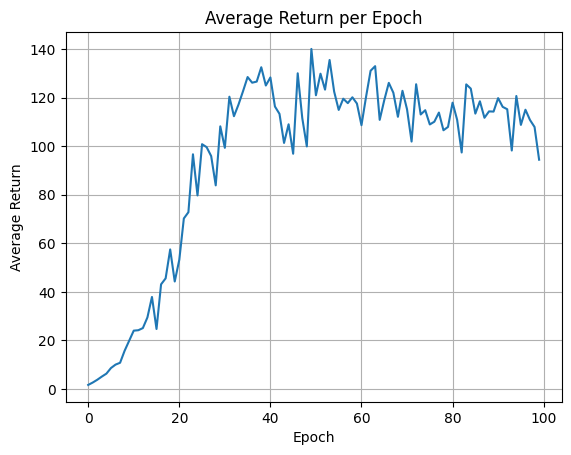

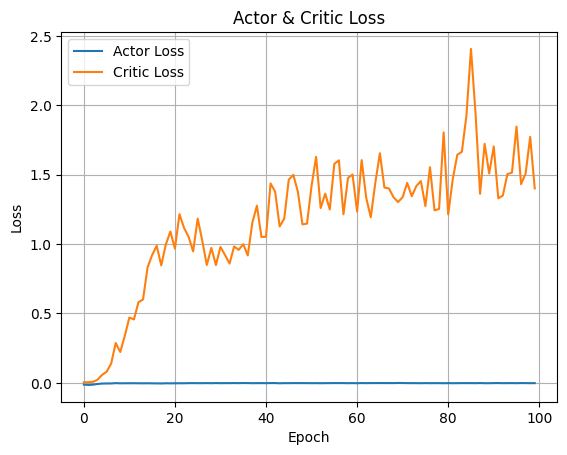

[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe


[INFO] Loaded actor from ppo_checkpoints/models/actor_epoch_100.pth


[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 0, Num Scenarios : 1


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
if __name__ == "__main__":
    env = TopDownMetaDrive(dict(
        use_render=False,
        horizon=300,
        num_scenarios=100
    ))
    train(env)
    # env.close()
    # fixed_scenarios = [0, 5, 12, 37, 89]
    # test_fixed_scenarios(fixed_scenarios, model_path="ppo_checkpoints/models/actor_epoch_100.pth")  


In [ ]:
    env.close()
    fixed_scenarios = [0, 5, 12, 37, 89]
    test_fixed_scenarios(fixed_scenarios, model_path="ppo_checkpoints/models/actor_epoch_100.pth")    

[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500


[INFO] Loaded actor from ppo_checkpoints/models/actor_epoch_100.pth


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3


Saved GIF for scenario 0 (reward=105.04) to ppo_tests_gifs/scenario_0.gif


[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 5, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe


Saved GIF for scenario 5 (reward=70.25) to ppo_tests_gifs/scenario_5.gif


[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 12, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3


Saved GIF for scenario 12 (reward=71.24) to ppo_tests_gifs/scenario_12.gif


[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 37, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)


Saved GIF for scenario 37 (reward=76.51) to ppo_tests_gifs/scenario_37.gif


[INFO] Start Scenario Index: 89, Num Scenarios : 1


Saved GIF for scenario 89 (reward=143.11) to ppo_tests_gifs/scenario_89.gif


: 